In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import Src.YamlUtils as yu
import Src.DicData as dade
import Src.Slideshow as slide

In [3]:
import os

img_path = "Z:/ForschB/comma_ai_extracted/{}/imgs"
train_path = "Z:/ForschB/comma_ai_extracted"
comma_ai_train_yaml = "Z:/ForschB/comma_ai_extracted/{}/training.yaml"

dirs = os.listdir(train_path)

yamls = []

for d in dirs:
    yamls.append(comma_ai_train_yaml.format(d))

In [4]:
dicts = []

for y in yamls:
    dicts.append(yu.read_yaml(y))

In [5]:
def do_all(dic):
    dade.remove_data_with_speed_lower_than_threshold(dic)
    max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dic)
    
    dade.add_speed_classes_to_dic(dic, threshold=0.05)
    
    dade.normalize_dic_steering(dic, max_abs_steer)
    # dade.normalize_dic_speed(dic, max_abs_speed)
    
    dade.add_steer_classes_to_dic(dic)
    dade.add_speed_cost_weight_to_dic(dic)
    dade.add_steer_cost_weight_to_dic(dic)
    
    return max_abs_steer, max_abs_speed

In [6]:
max_steers = []
max_speeds = []

for d in dicts:
    max_steer, max_speed = do_all(d)
    max_steers.append(max_steer)
    max_speeds.append(max_speed)

In [7]:
import copy

def copy_dic_till_key(dic, key):
    result = {}
    
    for k in dic:
        result[k] = copy.deepcopy(dic[k])
        
        if k == key:
            break
    
    return result

def copy_dic_from_till_keys(dic, f, t):
    result = {}
    
    do_copy = False
    
    for k in dic:
        
        if k == f:
            do_copy = True
        
        if do_copy:
            result[k] = copy.deepcopy(dic[k])
        
        if k == t:
            break
    
    return result

In [8]:
# TOUR 1
dict00_co = copy_dic_till_key(dicts[0],  4240) # tour 1 day
dict02_co = copy_dic_till_key(dicts[2],  4600) # tour 1 night
dict04_co = copy_dic_till_key(dicts[4],  3600) # tour 1 sunny morning
dict07_co = copy_dic_till_key(dicts[7],  6950) # tour 1 with extra steps, day
dict08_co = copy_dic_till_key(dicts[8],  6800) # tour 1 with extra steps, night
dict10_co = copy_dic_till_key(dicts[10], 4700) # tour 1 day

# TOUR 2
dict03_co = copy_dic_till_key(dicts[3],  8600) # tour 2 cloudy day

# TOUR 3
dict05_co = copy_dic_till_key(dicts[5], 11100) # tour 3 night not so useful

# TOUR 4
dict06_co = copy_dic_till_key(dicts[6],  9700) # tour 4 sunny day

# TOUR LONG DRIVE 1
dict01_co = copy_dic_till_key(dicts[1], 14590) # long drive 1 day

# TOUR LONG DRIVE 2
dict09_co = copy_dic_till_key(dicts[9], 24100) # long drive 2 night

In [9]:
dict00_ho = copy_dic_from_till_keys(dicts[0], 4240, 33300)
dict04_ho = copy_dic_from_till_keys(dicts[4], 3600, 10625)

In [10]:
max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dict00_ho)
dade.normalize_dic_steering(dict00_ho, max_abs_steer - 0.05)

dade.add_steer_classes_to_dic(dict00_ho)
dade.add_steer_cost_weight_to_dic(dict00_ho)

# max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dict04_ho)
dade.normalize_dic_steering(dict04_ho, max_abs_steer - 0.05)

dade.add_steer_classes_to_dic(dict04_ho)
dade.add_steer_cost_weight_to_dic(dict04_ho)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import copy


def analyze_steer_in_dic(dic, verbose=1):
    n_steer_classes = len(list(dic.values())[0]["steering_class"])
    
    steer_results = [ [] for _ in range(n_steer_classes) ]
    
    for k, v in dic.items():
        
        steering_class = v["steering_class"]
        steer_results[np.argmax(steering_class)].append(k)
    
    values = [len(l) for l in steer_results]
    
    if verbose > 0:
        print("==================================================")
        print("distribution in dict \n")
        
        for i, l in enumerate(steer_results):
            print(f"{i}: {len(l)}")

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        xlabel = range(n_steer_classes)
        ax.bar(xlabel, values)
        plt.show()
        
    return steer_results


def oversample_steer_in_dic(dic, steer_key_list, verbose=1):
    
    n_steer_classes = len(list(dic.values())[0]["steering_class"])
    
    values = [len(l) for l in steer_key_list]
    
    max_n_steer_class = max(values) 
    
    oversampled_steer_key_list = copy.deepcopy(steer_key_list)
    
    for l in oversampled_steer_key_list:
        
        tmp = list(l)
        
        if len(l) <= 0:
            continue
        
        for _ in range( (max_n_steer_class // len(l)) - 1):
            
            for e in tmp:
            
                l.append(e)
    
    if verbose > 0:
        print("==================================================")
        print("distribution after oversampling \n")
        
        for i, l in enumerate(oversampled_steer_key_list):
            print(f"{i}: {len(l)}")

            
        values = [len(l) for l in oversampled_steer_key_list]
            
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        xlabel = range(n_steer_classes)
        ax.bar(xlabel, values)
        plt.show()
        
        
    i = 0
    result = {}
        
    for l in oversampled_steer_key_list:
        
        for k in l:
            
            result[i] = dic[k]
            result[i]["img_name"] = k
            
            i += 1
            
    return result

In [ ]:
analyze_steer_in_dic(dicts[0])

distribution in dict 

0: 281
1: 55
2: 258
3: 701
4: 1409
5: 4291
6: 13235
7: 5607
8: 1678
9: 754
10: 384
11: 222
12: 186


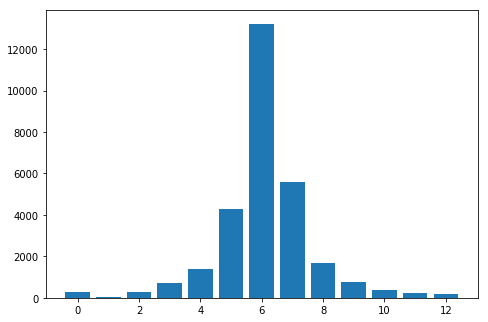

In [12]:
steer_key_list = analyze_steer_in_dic(dict00_ho)

In [14]:
print(steer_key_list[0])

[6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6821, 6822, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 684

distribution after oversampling 

0: 13207
1: 13255
2: 13158
3: 12618
4: 12681
5: 12873
6: 13296
7: 11242
8: 11746
9: 12818
10: 13056
11: 13098
12: 13209


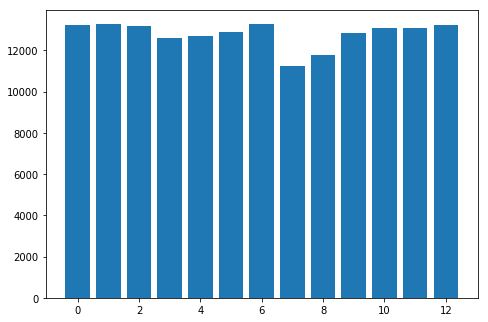

In [15]:
oversampled_dict00_ho = oversample_steer_in_dic(dict00_ho, steer_key_list)

In [13]:
import cv2

def load_imgs_from_dic(dic, img_path, img_file_type, keys):
    imgs = []
    
    for key in keys:
        img_name = key
        if "img_name" in dic[key].keys():
            img_name = dic[key]["img_name"]
        
        file_name = "{}/{}.{}".format(img_path, img_name, img_file_type)

        img = cv2.imread(file_name)
        
        imgs.append(img)
        
    return imgs
        

In [16]:
keys = [6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 
        6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 
        6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 
        6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 
        6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 
        6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728]


imgs = load_imgs_from_dic(dict00_ho, img_path.format(dirs[0]), "png", keys)

In [17]:
print(len(imgs))

83


In [18]:
test = imgs[0][0][0][0]

test = test // 2.0

print(type(test))

mean_img1 = ((imgs[0]) + (imgs[1])) // 2

mean_img2 = ((imgs[0] / 255.0) + mean_img1) / 2.0

mean_img3 = ((imgs[0] / 255.0) + mean_img2) / 2.0

mean_img4 = ((imgs[0] / 255.0) + mean_img3) / 2.0


cv2.imshow("img0", (imgs[0] / 255.0))
cv2.imshow("img1", (imgs[1] / 255.0))

cv2.imshow("mean1",  mean_img1)
cv2.imshow("mean2",  mean_img2)
cv2.imshow("mean3",  mean_img3)
cv2.imshow("mean4",  mean_img4)

cv2.imshow("diff3",  abs(mean_img3 - (imgs[0] / 255.0)))
cv2.imshow("diff4",  abs(mean_img4 - (imgs[0] / 255.0)))

print(np.sum(abs(mean_img3 - (imgs[0] / 255.0))))
print(np.sum(abs(mean_img4 - (imgs[0] / 255.0))))

# cv2.imshow("diff10", (imgs[1] / 255.0) - (imgs[0] / 255.0))

# cv2.imshow("diffm0",  mean_img - (imgs[0] / 255.0))
# cv2.imshow("diff1m",  (imgs[1] / 255.0) - mean_img)



cv2.waitKey(0)
cv2.destroyAllWindows()

<class 'numpy.float64'>
2675587.118627451
1337793.5593137254


In [14]:
def stretch_imgs(imgs, stretch_rounds=3):
    
    result = []
    
    # normalize
    for img in imgs:
        result.append(img / 255.0)
    
    for _ in range(stretch_rounds):
        
        imgs_to_add = []
        
        for i in range( (len(result) - 1) ):
            
            mean_img = (result[i+1] + result[i]) / 2.0
            imgs_to_add.append((i+1, mean_img))
        
        
        idx_offset = 0
        
        for i, img in imgs_to_add:
            result.insert(i + idx_offset, img)
            idx_offset +=1
        
    return result

In [39]:
stretched_imgs = stretch_imgs(imgs[0:2], 4)
print(len(stretched_imgs))

17


In [15]:
def show_imgs(imgs):
    for img in imgs:
        cv2.imshow("stretch show", img)
        k = cv2.waitKey(1000 // 100)
    
        if k == 27:
            break
        
    cv2.destroyAllWindows()

In [114]:
show_imgs(imgs)
show_imgs(stretched_imgs)

In [26]:
import Src.YamlUtils as yu
import os

def sort_key_list(keys):
    result = []
    
    tmp = []
    pre_key = None
    
    length = len(keys)
    
    if length == 1:
        result.append(keys[0])
        
    else:
        for i, key in enumerate(keys):

            if pre_key is not None:

                if (key - 1) == pre_key:
                    tmp.append(key)
                    pre_key = key

                    if i == (length - 1):
                        result.append(tmp)

                else:
                    result.append(tmp)

                    tmp = []
                    tmp.append(key)
                    pre_key = key

                    if i == (length - 1):
                        result.append(tmp)

            else:
                tmp.append(key)
                pre_key = key
            
    return result

def calc_number_of_stretched_stream_imgs(n_imgs, n_stretch_rounds):
    return (n_imgs - 1) * 2**(n_stretch_rounds) + 1

def calc_number_of_stretched_stream_imgs_based_on_sorted_keys(keys, n_stretch_rounds):
    result = 0
    
    for l in keys:
        result += calc_number_of_stretched_stream_imgs(len(l), n_stretch_rounds)
        
    return result

def calc_n_stretch_rounds_based_on_sorted_keys(n_max_imgs, keys):
    
    n_rounds = 5
    
    while True:
        n_imgs = calc_number_of_stretched_stream_imgs_based_on_sorted_keys(keys, n_rounds)
    
        if n_imgs < n_max_imgs:
            n_rounds += 1
            
            n_imgs_now = calc_number_of_stretched_stream_imgs_based_on_sorted_keys(keys, n_rounds)
            
            if n_imgs_now > n_max_imgs:
                # diff1 = abs(n_max_imgs - n_imgs)
                # diff2 = abs(n_max_imgs - n_imgs_now)
                
                # if diff1 <= diff2:
                n_rounds -= 1
                break
                # else:
                #     break
            
        elif n_imgs > n_max_imgs:
            n_rounds -= 1
            
            n_imgs_now = calc_number_of_stretched_stream_imgs_based_on_sorted_keys(keys, n_rounds)
            
            if n_imgs_now < n_max_imgs:
                # diff1 = abs(n_max_imgs - n_imgs)
                # diff2 = abs(n_max_imgs - n_imgs_now)
                
                # if diff1 < diff2:
                #     n_rounds += 1
                #     break
                # else:
                break
            
        else:
            break
    
    return n_rounds

def load_imgs_from_dic(dic, img_path, img_file_type, keys):
    imgs = []
    
    for key in keys:
        img_name = key
        if "img_name" in dic[key].keys():
            img_name = dic[key]["img_name"]
        
        file_name = "{}/{}.{}".format(img_path, img_name, img_file_type)

        img = cv2.imread(file_name)
        
        imgs.append(img)
        
    return imgs

def stretch_data(data, stretch_rounds=3):
    
    result = copy.deepcopy(data)
    
    for _ in range(stretch_rounds):
        
        data_to_add = []
        
        for i in range( (len(result) - 1) ):
            
            mean_data = (result[i+1] + result[i]) / 2.0
            data_to_add.append((i+1, mean_data))
        
        
        idx_offset = 0
        
        for i, dat in data_to_add:
            result.insert(i + idx_offset, dat)
            idx_offset +=1
        
    return result

def get_values_from_dic(dic, keys, target_key):
    
    result = []
    
    for key in keys:
        value = dic[key][target_key]
        result.append(value)
        
    return result

def key_in_dic(dic, key, default_key):
    if key in dic.keys():
        return key
    else:
        return default_key

def create_dirs(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == os.errno.EEXIST and os.path.isdir(path):
            pass
        else:
            print("Could not create dir {}".format(path))
            raise

def num_after_point(x):
    s = str(x)
    if not '.' in s:
        return 0
    return len(s) - s.index('.') - 1
            
def oversamle_stream_steer_data(dic, img_path, dest_path, img_file_type="png", dest_img_file_type="png", verbose=0):
    
    steer_key_lists = analyze_steer_in_dic(dic, verbose=verbose)
    
    max_n_samples_in_steer_class = max([len(l) for l in steer_key_lists])
    
    result_dic = {}
    
    create_dirs(dest_path + "/imgs")
    
    for key_list in steer_key_lists:
        
#         if len(key_list) == max_n_samples_in_steer_class:
#             continue
        
        sorted_key_list = sort_key_list(key_list)
        
        n_stretch_rounds = calc_n_stretch_rounds_based_on_sorted_keys(max_n_samples_in_steer_class, sorted_key_list)
        
        for keys in sorted_key_list:
            
            if len(key_list) != max_n_samples_in_steer_class:
                imgs = load_imgs_from_dic(dic, img_path, img_file_type, keys)
            
                steer_key = key_in_dic(dic[keys[0]], "orig_steering", "steering")
                steers = get_values_from_dic(dic, keys, steer_key)
            
                speed_key = key_in_dic(dic[keys[0]], "orig_speed", "speed")
                speeds = get_values_from_dic(dic, keys, speed_key)
            
                # normalize
                imgs = [img / 255.0 for img in imgs]
            
                stretched_imgs = stretch_data(imgs, n_stretch_rounds)
                del imgs
            
                stretched_steers = stretch_data(steers, n_stretch_rounds)
                del steers
            
                stretched_speeds = stretch_data(speeds, n_stretch_rounds)
                del speeds
            
                new_keys = list(np.linspace(keys[0], keys[-1], len(stretched_imgs), dtype=float))
            
                # denormalize
                stretched_imgs = [np.uint8(stretched_img * 255.0) for stretched_img in stretched_imgs]
                
            else:
                stretched_imgs = load_imgs_from_dic(dic, img_path, img_file_type, keys)
                
                steer_key = key_in_dic(dic[keys[0]], "orig_steering", "steering")
                stretched_steers = get_values_from_dic(dic, keys, steer_key)
                
                speed_key = key_in_dic(dic[keys[0]], "orig_speed", "speed")
                stretched_speeds = get_values_from_dic(dic, keys, speed_key)
                
                new_keys = keys
            
            # show_imgs(stretched_imgs)
            for new_key, stretched_img in zip(new_keys, stretched_imgs):
                cv2.imwrite(dest_path + "/imgs/{}.{}".format(float(new_key), dest_img_file_type), stretched_img)
            
            del stretched_imgs
            
            for key, steer, speed in zip(new_keys, stretched_steers, stretched_speeds):
                
                key = float(key)
                
                result_dic[key] = {}
                result_dic[key]["steering"] = float(steer)
                result_dic[key]["speed"] = float(speed)
            
    yu.write_dict_to_yaml(dest_path + "/training.yaml", result_dic)

In [27]:
oversamle_stream_steer_data(dict00_ho, img_path.format(dirs[0]), "Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho")

In [37]:
test_dict = yu.read_yaml("Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/training.yaml")

In [38]:
# do_all(test_dict)

dade.remove_data_with_speed_lower_than_threshold(test_dict)
dade.add_speed_classes_to_dic(test_dict, threshold=0.05)

dade.normalize_dic_steering(test_dict, max_steers[0])

dade.add_speed_cost_weight_to_dic(test_dict)


# after
max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(test_dict)
dade.normalize_dic_steering(test_dict, max_abs_steer - 0.05)

dade.add_steer_classes_to_dic(test_dict)
dade.add_steer_cost_weight_to_dic(test_dict)

0.07518062878344073


In [128]:
import Src.Slideshow as slide

slide.slideshow(test_dict, 
                "Z:/ForschB/comma_ai_oversampled/stream_oversample_comma.ai_dict00_ho/imgs", 
                minimal_steer=-1.0, maximal_steer=1.0,
                minimal_speed=0.0, maximal_speed=max_abs_speed,
                hz=100, img_file_type="png")

Key: 4240.0
Key: 4240.5
Key: 4241.0
Key: 4241.5
Key: 4242.0
Key: 4242.5
Key: 4243.0
Key: 4243.5
Key: 4244.0
Key: 4244.5
Key: 4245.0
Key: 4245.5
Key: 4246.0
Key: 4247.0
Key: 4248.0
Key: 4249.0
Key: 4250.0
Key: 4251.0
Key: 4252.0
Key: 4253.0
Key: 4254.0
Key: 4255.0
Key: 4256.0
Key: 4256.25
Key: 4256.5
Key: 4256.75
Key: 4257.0
Key: 4257.25
Key: 4257.5
Key: 4257.75
Key: 4258.0
Key: 4259.0
Key: 4260.0
Key: 4260.0625
Key: 4260.125
Key: 4260.1875
Key: 4260.25
Key: 4260.3125
Key: 4260.375
Key: 4260.4375
Key: 4260.5
Key: 4260.5625
Key: 4260.625
Key: 4260.6875
Key: 4260.75
Key: 4260.8125
Key: 4260.875
Key: 4260.9375
Key: 4261.0
Key: 4261.0625
Key: 4261.125
Key: 4261.1875
Key: 4261.25
Key: 4261.3125
Key: 4261.375
Key: 4261.4375
Key: 4261.5
Key: 4261.5625
Key: 4261.625
Key: 4261.6875
Key: 4261.75
Key: 4261.8125
Key: 4261.875
Key: 4261.9375
Key: 4262.0
Key: 4262.0625
Key: 4262.125
Key: 4262.1875
Key: 4262.25
Key: 4262.3125
Key: 4262.375
Key: 4262.4375
Key: 4262.5
Key: 4262.5625
Key: 4262.625
Key: 4

Key: 4388.0
Key: 4388.125
Key: 4388.25
Key: 4388.375
Key: 4388.5
Key: 4388.625
Key: 4388.75
Key: 4388.875
Key: 4389.0
Key: 4389.125
Key: 4389.25
Key: 4389.375
Key: 4389.5
Key: 4389.625
Key: 4389.75
Key: 4389.875
Key: 4390.0
Key: 4390.125
Key: 4390.25
Key: 4390.375
Key: 4390.5
Key: 4390.625
Key: 4390.75
Key: 4390.875
Key: 4391.0
Key: 4392.0
Key: 4392.0625
Key: 4392.125
Key: 4392.1875
Key: 4392.25
Key: 4392.3125
Key: 4392.375
Key: 4392.4375
Key: 4392.5
Key: 4392.5625
Key: 4392.625
Key: 4392.6875
Key: 4392.75
Key: 4392.8125
Key: 4392.875
Key: 4392.9375
Key: 4393.0
Key: 4393.0625
Key: 4393.125
Key: 4393.1875
Key: 4393.25
Key: 4393.3125
Key: 4393.375
Key: 4393.4375
Key: 4393.5
Key: 4393.5625
Key: 4393.625
Key: 4393.6875
Key: 4393.75
Key: 4393.8125
Key: 4393.875
Key: 4393.9375
Key: 4394.0
Key: 4394.0625
Key: 4394.125
Key: 4394.1875
Key: 4394.25
Key: 4394.3125
Key: 4394.375
Key: 4394.4375
Key: 4394.5
Key: 4394.5625
Key: 4394.625
Key: 4394.6875
Key: 4394.75
Key: 4394.8125
Key: 4394.875
Key: 43

distribution in dict 

0: 17606
1: 11275
2: 14811
3: 10346
4: 10481
5: 16177
6: 13235
7: 10876
8: 12661
9: 11359
10: 11451
11: 13263
12: 13407


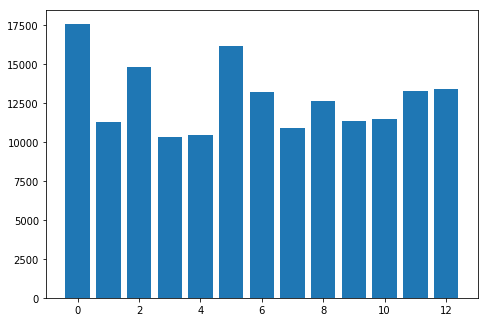

[[6646.0,
  6646.015625,
  6646.03125,
  6646.046875,
  6646.0625,
  6646.078125,
  6646.09375,
  6646.109375,
  6646.125,
  6646.140625,
  6646.15625,
  6646.171875,
  6646.1875,
  6646.203125,
  6646.21875,
  6646.234375,
  6646.25,
  6646.265625,
  6646.28125,
  6646.296875,
  6646.3125,
  6646.328125,
  6646.34375,
  6646.359375,
  6646.375,
  6646.390625,
  6646.40625,
  6646.421875,
  6646.4375,
  6646.453125,
  6646.46875,
  6646.484375,
  6646.5,
  6646.515625,
  6646.53125,
  6646.546875,
  6646.5625,
  6646.578125,
  6646.59375,
  6646.609375,
  6646.625,
  6646.640625,
  6646.65625,
  6646.671875,
  6646.6875,
  6646.703125,
  6646.71875,
  6646.734375,
  6646.75,
  6646.765625,
  6646.78125,
  6646.796875,
  6646.8125,
  6646.828125,
  6646.84375,
  6646.859375,
  6646.875,
  6646.890625,
  6646.90625,
  6646.921875,
  6646.9375,
  6646.953125,
  6646.96875,
  6646.984375,
  6647.0,
  6647.015625,
  6647.03125,
  6647.046875,
  6647.0625,
  6647.078125,
  6647.09375,
  6647

In [51]:
analyze_steer_in_dic(test_dict)

In [ ]:
analyze_steer_in_dic(test_dict)

In [28]:
print(test_dict[list(test_dict.keys())[0]])

{'speed': 21.65346640362195, 'steering': 0.08060241587888137, 'speed_class': array([0., 1., 0.]), 'orig_steering': 10.393681527581748, 'speed_cost_weight': 8.834629835423613, 'steering_class': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'steer_cost_weight': 0.7077636604898232}


In [50]:
for key in test_dict:
    if "steering_class" not in test_dict[key].keys():
        print(key)

In [48]:
print(test_dict[33180.0])

{'speed': 18.559203747783354, 'steering': 2.029031944346956, 'speed_class': array([0., 0., 1.]), 'orig_steering': 261.6436692235399, 'speed_cost_weight': 8.448357876625677, 'steer_cost_weight': 0.7077636604898232}


In [42]:
for key in dict00_ho:
    if dict00_ho[key]["steering"] > 1 or dict00_ho[key]["steering"] < -1:
        print(key)

6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6704
6705
6706
6707
6708
6709
6710
6711
6712
6747
6756
6757
6758
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
25170
25171
25204
25205
33168
33169
33170
33171
33172
33173
33174
33175
33176
33177
33178
33179
33180
33181
33182
33183
33184
33185
33186
33187
33188
33189
33190
33191
33192
33193
33194
33195
33196
33197
33198
33199
33200
33201
33202
33203
33204
33205
33206
33207
33208
33209
33210
33211
33212
33213
33214
33215
33216
33217
33218
33219
33220
33221
33222
33223
33224
33225
33226
33227
33228
33229
33230
33231
33232
33233
33234
33235
33236
33237
33238
33239
33240
33241
33242
33243
33244
33245
33246
33247
33248
33249
33250
33251
33252
33253
33254
33255
33256
33257
33258
33259
33260
33261
33262
33263
33264
33265
33266
33267
33268
33269
33270
332

In [45]:
print(dict00_ho[33180])

{'speed': 18.559203747783354, 'steering': 2.029031944346956, 'speed_class': array([0., 0., 1.]), 'orig_steering': 261.6436692235399, 'steering_class': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'speed_cost_weight': 1.5443687794656888, 'steer_cost_weight': 0.6707984211619694}
